In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

print("All packages imported successfully!")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


All packages imported successfully!
/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/input/train-labels-cafa5/random_forest_pickle_thousand
/kaggle/input/train-labels-cafa5/random_forest_pickle
/kaggle/input/train-labels-cafa5/train_labels.csv


In [3]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU device found: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Training on CPU.")

GPU device found: /device:GPU:0


In [4]:
prot_df = pd.DataFrame(
    np.load('/kaggle/input/t5embeds/train_embeds.npy'),
    index= np.load('/kaggle/input/t5embeds/train_ids.npy')
)
prot_labels = pd.read_csv('/kaggle/input/train-labels-cafa5/train_labels.csv')
prot_labels.drop("Unnamed: 0",axis=1,inplace=True)
prot_labels.set_index(prot_df.index,inplace=True)

In [5]:
train_df,test_df, train_labels, test_labels = train_test_split(
    prot_df, prot_labels,
    test_size= 0.4,
    random_state= 42
)

In [6]:
def scale_datasets(x_train, x_test):
  """
  Standard Scale test and train data
  """
  standard_scaler = MinMaxScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
  
train_df_scaled, test_df_scaled = scale_datasets(train_df, test_df)

In [7]:
class AutoEncoder (tf.keras.Model):
    """
    Design a Autoencoder model for the data to reduce the dimensions.
    """
    
    def __init__(self, output_units):
        """
        Initialise the class
        """
        super().__init__()
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(1024, activation= 'relu'),
                tf.keras.layers.Dense(512, activation= 'relu'),
                tf.keras.layers.Dense(256, activation= 'relu', name= 'sequential')
            ]
        )
        
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(512, activation= 'relu'),
                tf.keras.layers.Dense(1024, activation= 'relu'),
                tf.keras.layers.Dense(output_units, activation= 'sigmoid')
            ]
        )
    
    
    
    def call(self, inputs):
        """
        Call the AutoEncoder
        """
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
tf.device?

Signature: tf.device(device_name)
Docstring:
Specifies the device for ops created/executed in this context.

This function specifies the device to be used for ops created/executed in a
particular context. Nested contexts will inherit and also create/execute
their ops on the specified device. If a specific device is not required,
consider not using this function so that a device can be automatically
assigned.  In general the use of this function is optional. `device_name` can
be fully specified, as in "/job:worker/task:1/device:cpu:0", or partially
specified, containing only a subset of the "/"-separated fields. Any fields
which are specified will override device annotations from outer scopes.

For example:

```python
with tf.device('/job:foo'):
  # ops created here have devices with /job:foo
  with tf.device('/job:bar/task:0/device:gpu:2'):
    # ops created here have the fully specified device above
  with tf.device('/device:gpu:1'):
    # ops created here have the device '/job:foo/de

In [14]:
%%time

with tf.device('/device:GPU:0'):

    
#     Initialise the model
    autoencoder = AutoEncoder(len(train_df_scaled.columns))


#     compile the model
    autoencoder.compile(
        loss = 'mae',
        metrics = ['mae'],
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    )

    
#     train the model
    NUM_EPOCHS = 10
    BATCH_SIZE = int(train_df.shape[0]/500)


    history = autoencoder.fit(
        train_df_scaled, train_df_scaled,
        epochs = NUM_EPOCHS,
        batch_size = BATCH_SIZE,
        validation_data=(test_df_scaled, test_df_scaled)
    )

    

Epoch 1/10
503/503 [==============================] - 12s 12ms/step - loss: 0.0520 - mae: 0.0520 - val_loss: 0.0475 - val_mae: 0.0475
Epoch 2/10
503/503 [==============================] - 4s 7ms/step - loss: 0.0429 - mae: 0.0429 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 3/10
503/503 [==============================] - 3s 6ms/step - loss: 0.0389 - mae: 0.0389 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 4/10
503/503 [==============================] - 3s 6ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 5/10
503/503 [==============================] - 4s 7ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 6/10
503/503 [==============================] - 4s 8ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 7/10
503/503 [==============================] - 5s 10ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 8/10
503/503 [==============================] - 3s 7ms/step - loss:

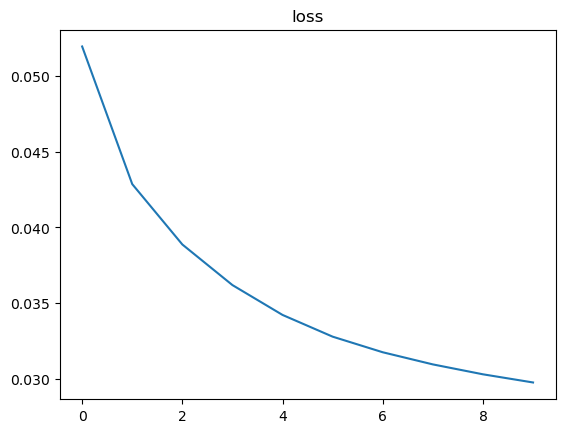

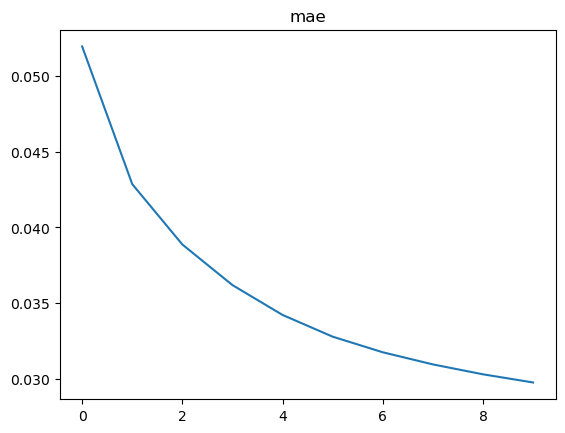

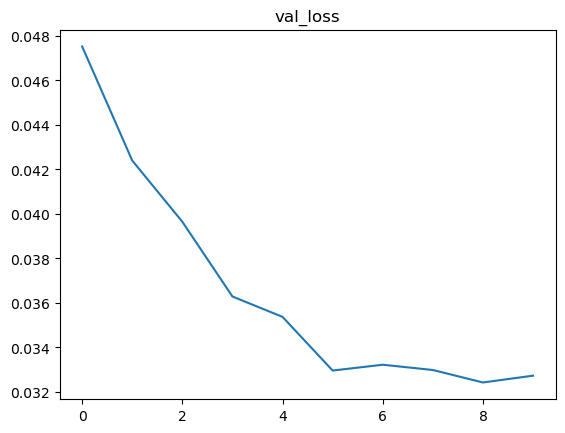

In [ ]:
history_df = pd.DataFrame(history.history)
for col in history_df.columns:
    history_df[col].plot(title=col)
    plt.show()

In [ ]:
%%time

with tf.device('/device:GPU:0'):
    encoder_layer = autoencoder.get_layer('sequential_4')
    reduced_df = pd.DataFrame(encoder_layer.predict(train_df_scaled))
    reduced_df = reduced_df.add_prefix('feature_')
    reduced_df.head()